# TermDepositMLForecast

Author: [Shayawn.com](https://Shayawn.com)

# Introduction

The `TermDepositMLForecast` project is aimed at predicting the likelihood of bank clients subscribing to term deposits based on historical data. This task is essential in the financial sector as it assists in optimizing marketing strategies and enhancing customer engagement by targeting likely subscribers.

The project leverages a dataset from a Portuguese banking institution, detailing various aspects of client demographics, contact information, and economic indicators from direct marketing campaigns conducted through phone calls. By applying machine learning techniques, this project compares the predictive power of several algorithms to identify the most effective approach.

Our objective is to understand the factors influencing clients' decisions to subscribe to term deposits and to deploy predictive models that can accurately forecast these outcomes. Through our analysis, we aim to provide actionable insights that can be used to refine marketing approaches and increase subscription rates efficiently.


## Setup and Installation
This cell handles the setup of the environment required for running the project. It installs all necessary Python packages as specified in the `requirements.txt` file. This file lists all dependencies with their respective versions, ensuring that all users have a consistent environment, which is crucial for reproducibility of results.

In [1]:
!pip install -r ../requirements.txt

## Library Imports and Initial Configuration
This cell imports all necessary libraries and modules used throughout the project. Key libraries include:

- `pandas` and `numpy` for data manipulation,
- `seaborn` and `matplotlib.pyplot` for data visualization,
- Various modules from `sklearn` for machine learning tasks like model training, feature scaling, and model evaluation,
- `imblearn` libraries for handling imbalanced datasets using techniques like SMOTE.

Additionally, this cell sets global configurations to suppress warnings and to set the plot style, which helps in maintaining a clean output and consistent visualization style across all plots.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, roc_auc_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import KBinsDiscretizer
from scipy.stats import chi2_contingency
from sklearn.svm import SVC
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

## Data Management Class Definition
This cell defines a Python class `BankData`, which is responsible for handling the dataset operations. Key functionalities include:

1. **Loading Data**: The constructor (`__init__`) takes a dictionary of dataset paths and loads them into a dictionary of pandas DataFrames. This setup is beneficial for handling multiple data sources efficiently.
2. **Basic Information Display**: The `basic_info` method provides a summary of any specified dataset, including its shape, detailed information about data types, the first few rows, and descriptive statistics. This helps in getting a quick overview and understanding the structure of the data.
3. **Missing Value Check**: The `check_missing_values` method checks for any missing values in the dataset, essential for the preprocessing steps in data cleaning.
4. **Data Preprocessing**: The `preprocess_data` method prepares the dataset for modeling by performing operations such as feature selection, splitting the data into training and testing sets, and encoding categorical variables.
5. **Feature Engineering**: This method adds additional features to the dataset, such as binning numeric variables, which can help improve model performance by grouping values into bins.

This class centralizes data management tasks making the code cleaner and modular, which simplifies the processes of data loading, preprocessing, and feature engineering.


In [3]:
class BankData:
    def __init__(self, dataset_paths):
        self.df = {name: pd.read_csv(path, delimiter=';') for name, path in dataset_paths.items()}

    def basic_info(self, name):
        df = self.df[name]
        print(f"\n\n--- {name} Dataset ---")
        print("Shape:", df.shape)
        print("Info:")
        df.info()
        print("First 5 rows:")
        print(df.head())
        print("Summary statistics:")
        print(df.describe(include='all'))

    def check_missing_values(self, name):
        df = self.df[name]
        return df.isnull().sum()

    def preprocess_data(self, name):
        df = self.df[name]
        X = df.drop('y', axis=1)
        y = df['y'].map({'yes': 1, 'no': 0})
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        X_train, X_test = self.feature_engineering(X_train, X_test)
        return X_train, X_test, y_train, y_test

    def feature_engineering(self, X_train, X_test):
        binning = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
        X_train['age_bin'] = binning.fit_transform(X_train[['age']])
        X_test['age_bin'] = binning.transform(X_test[['age']])
        return X_train, X_test

    def get_data(self, name):
        return self.df[name]

## Data Visualization Tools

The `DataVisualizer` class provides a collection of static methods designed to facilitate the exploration and visualization of the dataset used in the TermDepositMLForecast project. Each method supports different aspects of data analysis, helping to understand distributions, correlations, and other statistical properties of the data.

- **plot_target_distribution:** Visualizes the distribution of the target variable across different datasets, which is crucial for understanding class imbalances that may influence model performance.
- **plot_histograms:** Generates histograms for numerical features to assess data distribution and identify potential outliers or skewed data.
- **plot_correlation_matrix:** Displays a heatmap of Pearson correlation coefficients between numerical features, helping identify multicollinearity or potential predictor relationships.
- **plot_boxplots:** Creates boxplots for each numerical feature to further investigate their distribution and spot outliers.
- **plot_categorical_distributions:** Shows the distribution of categorical variables segmented by the target variable, providing insights into how these predictors might influence the target outcome.
- **plot_roc_curves:** Plots Receiver Operating Characteristic (ROC) curves for models to compare their true positive rate and false positive rate, an essential metric for binary classification tasks.
- **plot_feature_importance:** If applicable, this method visualizes the importance of each feature used by the model, aiding in understanding which features most affect the output variable.


In [4]:
class DataVisualizer:
    @staticmethod
    def plot_target_distribution(df, target, name):
        plt.figure(figsize=(8, 4))
        total = float(len(df))
        ax = sns.countplot(x=target, data=df)
        plt.title(f"Distribution of Target Variable in {name} Dataset")
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2 - 0.05
            y = p.get_height()
            ax.annotate(percentage, (x, y), ha='center')
        plt.show()

    @staticmethod
    def plot_histograms(df):
        num_features = df.select_dtypes(include=['int64', 'float64']).columns
        df[num_features].hist(bins=15, figsize=(15, 6))
        plt.show()

    @staticmethod
    def plot_correlation_matrix(df):
        num_features = df.select_dtypes(include=['int64', 'float64']).columns
        correlation_matrix = df[num_features].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
        plt.title('Correlation Matrix')
        plt.show()

    @staticmethod
    def plot_boxplots(df):
        num_features = df.select_dtypes(include=['int64', 'float64']).columns
        plt.figure(figsize=(15, 10))
        for i, col in enumerate(num_features):
            plt.subplot(4, 4, i + 1)
            df.boxplot(column=col)
            plt.title(col)
        plt.tight_layout()
        plt.show()

    @staticmethod
    def plot_categorical_distributions(df):
        cat_features = df.select_dtypes(include=['object']).columns.drop('y')
        for feature in cat_features:
            crosstab_result = pd.crosstab(df[feature], df['y'])
            print(f"\n--- Crosstab of {feature} by Target 'y' ---")
            print(crosstab_result)
            crosstab_result.plot(kind='bar', figsize=(10, 4), stacked=True)
            plt.title(f'{feature} distribution by Target')
            plt.xlabel(f'{feature}')
            plt.ylabel('Frequency')
            plt.show()

    @staticmethod
    def plot_roc_curves(roc_data):
        plt.figure(figsize=(10, 8))
        for data in roc_data:
            plt.plot(data['fpr'], data['tpr'], label=f"{data['model']} (AUC = {data['auc']:.2f})")
        plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend(loc='lower right')
        plt.show()

    @staticmethod
    def plot_feature_importance(feature_importance):
        if feature_importance is not None:
            feature_importance.plot(kind='bar', figsize=(10, 6))
            plt.title('Feature Importance')
            plt.ylabel('Importance')
            plt.xlabel('Features')
            plt.show()
        else:
            print("Feature importance data is not available.")

### Feature Selection Process

In this section, we introduce the `FeatureSelector` class designed to identify the most relevant features for predicting whether a client will subscribe to a bank term deposit. The class utilizes several statistical techniques and model-based approaches to refine the feature set for the machine learning models.

- **Univariate Feature Selection (`univariate_selection`):** This method applies a univariate feature selection technique using ANOVA F-test via SelectKBest to identify the top n features that have the highest statistical significance with respect to the target. The selection is performed only on numerical data.
- **Model-based Feature Selection (`model_based_selection`):** Utilizes Recursive Feature Elimination with Cross-Validation (RFECV) using a RandomForestClassifier. This method is used after univariate feature selection to further refine the chosen features based on their importance derived from the model.
- **Chi-squared Test for Categorical Features (`chi_squared_test`):** Performs a chi-squared test to determine the significance of categorical features with respect to the target. Features with a p-value less than 0.06 are considered significant and are added to the list of selected features.
- **Retrieve Selected Features (`get_selected_features`):** Returns the final list of selected features that combines the results from both numerical and categorical selections.

The `FeatureSelector` is instantiated and used within the data preparation phase of the pipeline in `TermDepositMLForecast` class.

In [5]:
class FeatureSelector:
    def __init__(self, numerical_data, categorical_data, target):
        self.numerical_data = numerical_data
        self.categorical_data = categorical_data
        self.target = target
        self.selected_features = []
        self.num_features = []  # To store the names of selected numerical features

    def univariate_selection(self, num_features=10):
        # Keep column names first
        columns = self.numerical_data.columns
        selector = SelectKBest(f_classif, k=num_features)
        # Apply selector to numerical data
        transformed_data = selector.fit_transform(self.numerical_data, self.target)
        mask = selector.get_support()  # List of booleans for selected features
        selected_columns = columns[mask]  # Filter columns by mask
        self.num_features = selected_columns.tolist()
        self.selected_features += self.num_features
        # Ensure that numerical_data remains a DataFrame
        self.numerical_data = pd.DataFrame(transformed_data, columns=self.num_features)
        return self

    def model_based_selection(self):
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        selector = RFECV(estimator=model, step=1, cv=5)
        selected_data = self.numerical_data[self.num_features]  # Only select previously selected features
        selector.fit(selected_data, self.target)
        mask = selector.get_support()  # List of booleans for selected features
        reduced_features = [feature for feature, selected in zip(self.num_features, mask) if selected]
        self.num_features = reduced_features
        self.selected_features = reduced_features  # Only include selected features
        return self

    def chi_squared_test(self):
        significant_cats = []
        for column in self.categorical_data.columns:
            contingency_table = pd.crosstab(self.categorical_data[column], self.target)
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            if p < 0.06:  # Using 0.06 as the significance level
                significant_cats.append(column)
        self.selected_features += significant_cats
        return self

    def get_selected_features(self):
        return self.selected_features

## TermDepositMLForecast Class

This section outlines the functionality implemented in the `TermDepositMLForecast` class, which serves as the core component for preparing data, building predictive models, and evaluating their performance. This class encapsulates all functionalities required for forecasting whether a client will subscribe to a bank term deposit.

### Class Initialization

Upon instantiation, the `TermDepositMLForecast` class initializes its attributes including setting up the dataset path and creating instances for data visualization.

- `bank_data` loads the dataset specified by the path provided during initialization.
- `data_visualizer` is an instance of the `DataVisualizer` class, which will be used for visualizing data distributions and results.

### Data Preparation

The `prepare_data` method is responsible for the following:
- Loading and preprocessing the data using `BankData` class methods.
- Identifying numerical and categorical columns from the dataset.
- Feature selection is performed by an instance of the `FeatureSelector` class. It applies univariate selection, model-based selection using Random Forest, and a Chi-squared test for categorical variables to identify the most predictive features.
- The method updates the training (`X_train`) and testing (`X_test`) datasets to include only the selected features.

### Pipeline Construction

The `build_pipeline` method constructs a machine learning pipeline that includes:
- Data preprocessing using column transformers:
  - Numerical data is scaled.
  - Categorical data is encoded using one-hot encoding.
- Application of PCA (Principal Component Analysis) is optional and can be configured via the `use_pca` flag.
- SMOTE (Synthetic Minority Over-sampling Technique) is integrated to address class imbalance.
- A specified classifier is added to the pipeline.

#### Numerical Transformations

- **Imputation**: Missing values in numerical features are imputed using the median of each column, which is robust to outliers compared to the mean.
- **Scaling**: Data is standardized by removing the mean and scaling to unit variance. This step ensures that the magnitude of the numerical values does not bias the model, which is particularly important for models that rely on the distance between data points, like SVM.

#### Categorical Transformations

- **Imputation**: Missing values in categorical features are replaced with the string 'missing'. This approach treats missing data as a separate category, avoiding the introduction of bias that might occur if imputed with the most frequent category.
- **One-Hot Encoding**: Converts categorical variables into a form that could be provided to ML algorithms to do a better job in prediction. It creates binary columns for each category and assigns a value of 1 or 0. This encoding is essential for handling non-ordinal categorical variables in machine learning.

#### Principal Component Analysis (PCA)

- **PCA Application**: When the `use_pca` flag is set to True, PCA is applied to reduce the dimensionality of the data. It transforms the data into a new coordinate system, reducing the number of features while retaining the variance in the data as much as possible. This step can help in alleviating issues from the curse of dimensionality, especially in datasets with many features.

#### Synthetic Minority Over-sampling Technique (SMOTE)

- **Handling Class Imbalance**: SMOTE is used to oversample the minority class by creating synthetic samples. This approach helps to balance the dataset, improving the performance of the classifier on imbalanced data by addressing the issue where minority class observations are often overlooked or misclassified.

#### ImbPipeline

- **Enhanced Pipeline for Imbalanced Data**: Uses an `Imbalanced Pipeline` from the `imbalanced-learn` library, specifically designed to integrate resampling techniques seamlessly within the cross-validation process.

### Model Training and Hyperparameter Tuning

The `train_models` method:
- Initializes classifiers with their respective hyperparameters.
- For each classifier, a pipeline is built, optionally tuned using grid search or random search, and trained on the dataset.
- Model performance is evaluated using accuracy, precision, recall, F1 score, and ROC AUC metrics on both training and testing sets.
- The method returns the evaluation results and ROC curve data for further analysis and visualization.

### Classifiers and Their Attributes

- **Logistic Regression**: Utilized with attributes like `max_iter` for convergence and `solver` for optimization. Specific hyperparameters like `C` (regularization strength) and `penalty` (type of regularization) are tuned to optimize model performance.
- **Random Forest**: An ensemble method that uses a combination of decision trees. It is configured with hyperparameters such as `n_estimators` (number of trees), `max_depth` (depth of each tree), `min_samples_split`, and `min_samples_leaf` to control the fitting process.
- **Support Vector Machine (SVM)**: Applied with a linear kernel to balance complexity and performance. Hyperparameters like `C` (penalty parameter) and `gamma` (kernel coefficient) are essential for the model's sensitivity to the training data distribution.

### Model Evaluation

The `evaluate_model` method computes various performance metrics for the provided model and datasets to quantify its effectiveness in predicting whether clients will subscribe to a term deposit.

- **Accuracy**: Measures the overall correctness of the model, defined as the ratio of true predictions (both true positives and true negatives) to the total number of cases.
- **Precision**: Indicates the accuracy of positive predictions, formulated as the ratio of true positives to all predicted positives. High precision relates to a low rate of false positives.
- **Recall**: Measures the model's ability to detect positive instances, calculated as the ratio of true positives to all actual positives. High recall relates to a low rate of false negatives.
- **F1 Score**: Combines precision and recall into a single metric by taking their harmonic mean. It balances both metrics, especially useful when dealing with imbalanced datasets.
- **ROC AUC**: The area under the receiver operating characteristic curve. It evaluates the trade-off between the true positive rate and false positive rate, providing a single measure of general model performance across all classification thresholds.

### Feature Importance

The `get_feature_importance` method extracts feature importances from trained models, aiding in the interpretation of the models by highlighting which features most influence predictions.

### Hyperparameter Tuning Functions

- `perform_grid_search` and `perform_random_search` are implemented to fine-tune model parameters, aiming to improve model performance by searching over a specified parameter space and using cross-validation.

#### Grid Search and Random Search

- **Grid Search**: Conducts an exhaustive search over a specified parameter grid. This method trains and evaluates a model for each combination of algorithm parameters specified in a grid, facilitating the identification of the most optimal parameters.
- **Random Search**: Samples algorithm parameters from a grid of possible values. It offers a budget-friendly alternative to grid search by limiting the number of parameter combinations that are evaluated.

This structured approach ensures a robust framework for training and evaluating machine learning models, making it easier to compare different algorithms and their configurations.

### Getter Methods

- **`get_bank_data`**: Returns the `BankData` instance associated with the class. This instance contains the data and preprocessing methods necessary for the machine learning tasks.

- **`get_model`**: Fetches a specific trained model by name. This is useful when multiple models are trained and stored within the class.

- **`get_model_results`**: Retrieves the results of all models trained in the class. These results typically include metrics such as accuracy, precision, recall, F1 score, and ROC AUC for each model.

- **`get_roc_data`**: Provides the ROC curve data for each model. This data is essential for evaluating the trade-offs between the true positive rate and false positive rate at various threshold settings.

- **`get_selected_features`**: Returns the list of feature names that were selected as the most informative for predicting the outcome. This selection is based on the feature selection process applied during data preparation.

These methods provide a safe way to access the internal state of an instance of `TermDepositMLForecast` without directly exposing the class's fields to external modification.

In [6]:
class TermDepositMLForecast:
    def __init__(self):
        self.roc_data = []
        self.model_results = []
        self.selected_features = None
        self.bank_data = BankData({
                'Bank Additional Full': '../datasets/bank-additional-full.csv',
                # 'Bank Additional': '../datasets/bank-additional.csv',
                # 'Bank Full Old': '../datasets/bank-full.csv',
                # 'Bank Old': '../datasets/bank.csv'
            }
        )
        self.data_visualizer = DataVisualizer()
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.models = {}

    def prepare_data(self):
        self.X_train, self.X_test, self.y_train, self.y_test = self.bank_data.preprocess_data('Bank Additional Full')
        num_cols = [cname for cname in self.X_train.columns if self.X_train[cname].dtype in ['int64', 'float64']]
        cat_cols = [cname for cname in self.X_train.columns if self.X_train[cname].dtype == 'object']

        # Applying feature selection
        fs = FeatureSelector(self.X_train[num_cols], self.X_train[cat_cols], self.y_train)
        fs.univariate_selection().model_based_selection().chi_squared_test()
        self.selected_features = fs.get_selected_features()

        # Update X_train and X_test based on selected features
        self.X_train = self.X_train[self.selected_features]
        self.X_test = self.X_test[self.selected_features]

    def build_pipeline(self, classifier, use_pca=False):
        numerical_cols = [cname for cname in self.X_train.columns if self.X_train[cname].dtype in ['int64', 'float64']]
        categorical_cols = [cname for cname in self.X_train.columns if self.X_train[cname].dtype == "object"]

        numerical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),     # Impute missing values
            ('scaler', StandardScaler()),                      # Standardize features
        ])

        categorical_transformer = Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))      # Apply one-hot encoding
        ])

        # Choose whether to use PCA
        if use_pca:
            pca_transformer = Pipeline(steps=[
                ('scaler', StandardScaler()),  # Scaling is done before PCA
                ('pca', PCA(n_components=0.95))
            ])
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', pca_transformer, numerical_cols),
                    ('cat', categorical_transformer, categorical_cols)
                ])
        else:
            preprocessor = ColumnTransformer(
                transformers=[
                    ('num', numerical_transformer, numerical_cols),
                    ('cat', categorical_transformer, categorical_cols)
                ])

        # Final pipeline including SMOTE and classifier
        pipeline = ImbPipeline(steps=[
            ('preprocessor', preprocessor),
            ('smote', SMOTE(random_state=42)),  # Handle class imbalance
            ('classifier', classifier)  # Classifier
        ])
        return pipeline

    def train_models(self, use_pca=False, tune=False, tune_search_method='grid'):
        # Initializing the models
        # Define the classifiers to be used
        classifiers = {
            'Logistic Regression': (LogisticRegression(max_iter=1000, solver='liblinear'), log_reg_params),
            'Random Forest': (RandomForestClassifier(n_estimators=100, random_state=42), rf_params),
            'SVM': (SVC(kernel='linear', random_state=42, probability=True), svm_params)  # Linear kernel is chosen for simplicity and performance
        }

        results = []
        roc_data = []

        # Loop through the classifiers to create, train, and evaluate each one
        for name, (classifier, params) in tqdm(classifiers.items(), desc="Training Models"):
            try:
                pipeline = self.build_pipeline(classifier, use_pca=use_pca)

                if tune:
                    print(f"Performing {tune_search_method} hyperparameter tuning for {name}")
                    tuned_pipeline = None
                    if tune_search_method == 'grid':
                        tuned_pipeline = self.perform_grid_search(pipeline, params, self.X_train, self.y_train)
                    elif tune_search_method == 'random':
                        tuned_pipeline = self.perform_random_search(pipeline, params, self.X_train, self.y_train)
                    elif tune_search_method == 'both':
                        # Perform both searches, compare and choose the best
                        grid_pipeline = self.perform_grid_search(pipeline, params, self.X_train, self.y_train)
                        random_pipeline = self.perform_random_search(pipeline, params, self.X_train, self.y_train)
                        # Choosing the model with the best cross-validation ROC AUC score
                        tuned_pipeline = grid_pipeline if grid_pipeline.best_score_ >= random_pipeline.best_score_ else random_pipeline

                    pipeline = tuned_pipeline.best_estimator_  # Use the tuned pipeline
                    print(f"Training {name} with best parameters.")

                # Fit the model pipeline on the training data
                pipeline.fit(self.X_train, self.y_train)

                self.models[name] = pipeline  # Store the trained pipeline

                # Evaluate the model
                train_metrics, test_metrics, fpr, tpr, thresholds = self.evaluate_model(pipeline, self.X_train, self.y_train, self.X_test, self.y_test)

                # Collect results
                results.append({
                    'Model': name,
                    'Train Accuracy': train_metrics['Accuracy'],
                    'Test Accuracy': test_metrics['Accuracy'],
                    'Train Precision': train_metrics['Precision'],
                    'Test Precision': test_metrics['Precision'],
                    'Train Recall': train_metrics['Recall'],
                    'Test Recall': test_metrics['Recall'],
                    'Train F1': train_metrics['F1 Score'],
                    'Test F1': test_metrics['F1 Score'],
                    'Test ROC AUC': test_metrics['ROC AUC']
                })
                roc_data.append({'model': name, 'fpr': fpr, 'tpr': tpr, 'auc': test_metrics['ROC AUC']})
            except Exception as e:
                print(f"Error training {name}: {e}")

        # Create DataFrame for results
        self.model_results = pd.DataFrame(results)
        self.roc_data = roc_data
        return self.model_results, self.roc_data

    def evaluate_model(self, model, X_train, y_train, X_test, y_test):
        # Predictions on training and test set
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        y_prob_test = model.predict_proba(X_test)[:, 1]  # Get probabilities for the positive class

        # Compute metrics for training and testing sets
        metrics_train = {
            'Accuracy': accuracy_score(y_train, y_pred_train),
            'Precision': precision_score(y_train, y_pred_train),
            'Recall': recall_score(y_train, y_pred_train),
            'F1 Score': f1_score(y_train, y_pred_train),
            'ROC AUC': roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])  # ROC AUC for training
        }

        metrics_test = {
            'Accuracy': accuracy_score(y_test, y_pred_test),
            'Precision': precision_score(y_test, y_pred_test),
            'Recall': recall_score(y_test, y_pred_test),
            'F1 Score': f1_score(y_test, y_pred_test),
            'ROC AUC': roc_auc_score(y_test, y_prob_test)  # ROC AUC for testing
        }

        fpr, tpr, thresholds = roc_curve(y_test, y_prob_test)
        return metrics_train, metrics_test, fpr, tpr, thresholds

    def perform_grid_search(self, pipeline, param_grid, X_train, y_train, cv=5):
        """
        Perform grid search hyperparameter tuning.
        """
        grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv, scoring='roc_auc', verbose=2, n_jobs=-1)
        with tqdm(total=len(param_grid[next(iter(param_grid))]) * cv) as pbar:
            grid_search.fit(X_train, y_train)
            pbar.update(1)
        print("Best parameters:", grid_search.best_params_)
        print("Best cross-validation ROC AUC score: {:.3f}".format(grid_search.best_score_))
        return grid_search

    def perform_random_search(self, pipeline, param_distributions, X_train, y_train, n_iter=100, cv=5):
        """
        Perform random search hyperparameter tuning.
        """
        random_search = RandomizedSearchCV(estimator=pipeline, param_distributions=param_distributions, n_iter=n_iter, cv=cv, scoring='roc_auc', verbose=2, random_state=42, n_jobs=-1)
        with tqdm(total=n_iter * cv) as pbar:
            random_search.fit(X_train, y_train)
            pbar.update(1)
        print("Best parameters:", random_search.best_params_)
        print("Best cross-validation ROC AUC score: {:.3f}".format(random_search.best_score_))
        return random_search

    def get_feature_importance(self, pipeline, X_train):
        # Transform the data using the preprocessor to get the transformed feature matrix
        X_transformed = pipeline.named_steps['preprocessor'].transform(X_train.head(1))

        # Extract feature names after transformation
        if hasattr(pipeline.named_steps['preprocessor'], 'get_feature_names_out'):
            feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
        else:
            feature_names = [f"feature_{i}" for i in range(X_transformed.shape[1])]

        # Extract the model from the pipeline
        model = pipeline.named_steps['classifier']

        if hasattr(model, 'feature_importances_'):
            # Handle tree-based models
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            # Handle models with coefficients (like Logistic Regression)
            importances = np.abs(model.coef_[0])
        else:
            return None

        feature_importance = pd.DataFrame(importances, index=feature_names, columns=['importance'])
        feature_importance = feature_importance.sort_values(by='importance', ascending=False)
        return feature_importance

#     def get_feature_importance(self, model, feature_names):
#         feature_names = model.named_steps['preprocessor'].transform(feature_names).columns
#         model = model.named_steps['classifier']

#         if hasattr(model, 'feature_importances_'):
#             # Handle tree-based models
#             importances = model.feature_importances_
#         elif hasattr(model, 'coef_'):
#             # Handle models with coefficients (like Logistic Regression)
#             importances = np.abs(model.coef_[0])
#         else:
#             return None

#         feature_importance = pd.DataFrame(importances, index=feature_names, columns=['importance'])
#         feature_importance = feature_importance.sort_values(by='importance', ascending=False)
#         return feature_importance

    # Getters
    def get_bank_data(self):
        return self.bank_data

    def get_model(self, model_name):
        return self.models.get(model_name, None)

    def get_model_results(self):
        return self.model_results

    def get_roc_data(self):
        return self.roc_data

    def get_selected_features(self):
        return self.selected_features

## Hyperparameter Grids

This section outlines the definition of hyperparameter grids for the logistic regression, random forest, and SVM classifiers used in the `TermDepositMLForecast` project. These grids are used during the hyperparameter tuning process to find the optimal settings for each model.

### Logistic Regression Parameters

- **`classifier__C`**: The regularization strength, which inversely controls the amount of overfitting. Lower values increase regularization, which can help to reduce overfitting but may lead to underfitting if set too high. The values tested are `[0.01, 0.1, 1, 10, 100]`.
- **`classifier__penalty`**: Specifies the norm used in the penalization (regularization term). The options are `['l1', 'l2']`:
  - **`l1`**: Lasso regularization which adds a penalty equal to the absolute value of the magnitude of coefficients. This can lead to sparse models (with few coefficients set to zero).
  - **`l2`**: Ridge regularization which adds a penalty equal to the square of the magnitude of coefficients. This tends to distribute error among all the terms but doesn't set coefficients to zero.

### Random Forest Parameters

- **`classifier__n_estimators`**: The number of trees in the forest. Increasing the number of trees generally improves the performance but also increases the computational load. Values tested include `[50, 100, 200]`.
- **`classifier__max_depth`**: The maximum depth of each tree. Allowed values are `[None, 10, 20, 30]`, where `None` means no limit, potentially leading to fully grown and very deep trees which might overfit the data.
- **`classifier__min_samples_split`**: The minimum number of samples required to split an internal node. Higher values prevent the model from learning overly specific patterns, thus lowering overfitting. Tested values are `[2, 5, 10]`.
- **`classifier__min_samples_leaf`**: The minimum number of samples required to be at a leaf node. Like `min_samples_split`, this parameter affects the depth of the tree. The values being tested are `[1, 2, 4]`.

### SVM Parameters

- **`classifier__C`**: Penalty parameter C of the error term. It controls the trade off between smooth decision boundary and classifying the training points correctly. SVM performance is highly sensitive to this parameter. Values considered are `[0.1, 1, 10]`.
- **`classifier__gamma`**: Kernel coefficient for `rbf`, `poly` and `sigmoid`. Here, since we use a linear kernel, this parameter will be explored within the options `['scale', 'auto']`, which automates the selection of gamma based on the number of features (scale) or uses 1/n_features (auto).

### Purpose of Hyperparameter Tuning

Hyperparameter tuning is critical in optimizing the model's performance, balancing the bias-variance tradeoff, and ensuring that the model generalizes well to new, unseen data. Using GridSearchCV or RandomizedSearchCV in the training process helps in systematically working through multiple combinations of parameter values, directing the search into the region of the best performance of the model.


In [7]:
# Parameter grid for Logistic Regression
log_reg_params = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2']
}

# Parameter grid for Random Forest
rf_params = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

# Parameter grid for SVM
svm_params = {
    'classifier__C': [0.1, 1, 10],
    'classifier__gamma': ['scale', 'auto']
}

## Class Instantiation and Initializations
Here, we instantiate the `TermDepositMLForecast` class. This class manages the data preparation, model training, and visualization for our term deposit subscription prediction project. The instantiation process includes setting up the data paths, initializing the visualizer, and other components crucial for the data processing pipeline.

In [8]:
# Instantiating the class
TDMLForecast = TermDepositMLForecast()

# Bank Data
bank_data = TDMLForecast.bank_data

# Visualizations
visualizer = TDMLForecast.data_visualizer

## Data Preparation
This cell calls the `prepare_data` method of our forecast instance. This method is responsible for loading the dataset, performing initial splits between training and testing sets, and applying basic feature engineering. The method also handles the selection of features based on different criteria (e.g., univariate selection, model-based selection, chi-squared test for categorical variables) to refine the inputs for our models.

In [9]:
# Main Execution
forecast = TermDepositMLForecast()
forecast.prepare_data()  # Ensures data is loaded, split, and basic feature engineering is applied

## Model Training and Evaluation
In this cell, we train and evaluate three different machine learning models: Logistic Regression, Random Forest, and SVM. The models are trained without PCA application or hyperparameter tuning to establish a baseline performance. The training process involves constructing a pipeline with preprocessing steps (scaling, encoding), balancing (using SMOTE), and classifier training. Results and ROC data are captured for comparison.

In [10]:
results, roc_data = forecast.train_models(use_pca=False, tune=False)  # Train and compare different models

Training Models: 100%|██████████| 3/3 [19:52<00:00, 397.34s/it]


## Dataset Overview
Here, we retrieve and display basic information about the 'Bank Additional Full' dataset using our `BankData` class's `basic_info` method. This includes the dataset shape, data types, first few rows, and summary statistics, providing a quick overview and ensuring the data is loaded correctly and ready for further analysis.


In [11]:
data = bank_data.get_data('Bank Additional Full')

In [12]:
# Basic Information
bank_data.basic_info('Bank Additional Full')



--- Bank Additional Full Dataset ---
Shape: (41188, 21)
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.i

In this cell, we analyze the basic information about the 'Bank Additional Full' dataset. The dataset contains 41,188 entries and 21 columns covering client demographic information, campaign details, and economic indicators. Each variable is complete without any missing values, indicating a well-maintained dataset ready for analysis. The first few rows reveal a variety of jobs, marital statuses, and education levels, with a majority of clients not subscribing to a term deposit (`y = no`). Statistical summaries suggest diverse age distribution among clients (ranging from 17 to 98) and varied contact frequencies, with most clients not contacted before (`pdays = 999`). This preliminary data overview is crucial for understanding the dataset's structure and scope before diving deeper into analysis.


## Data Visualization
These cells focus on visualizing various aspects of the dataset to understand data distribution and relationships.


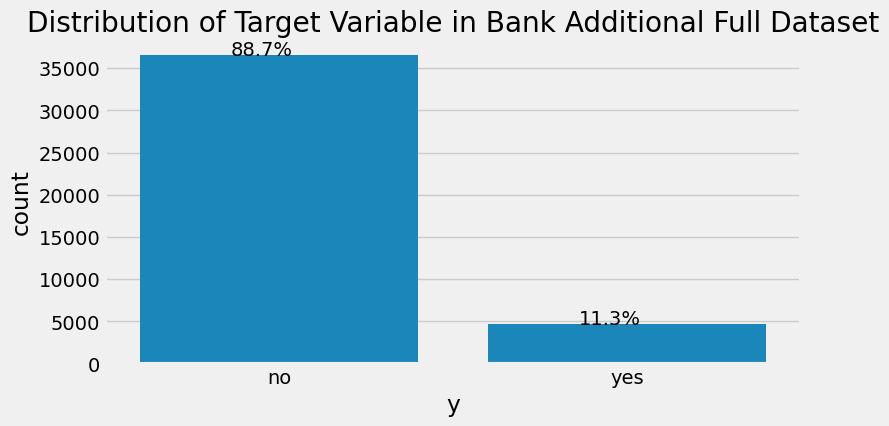

In [25]:
# Visualizing target distribution
visualizer.plot_target_distribution(data, 'y', 'Bank Additional Full')

Visualizes the distribution of the target variable (`y`).

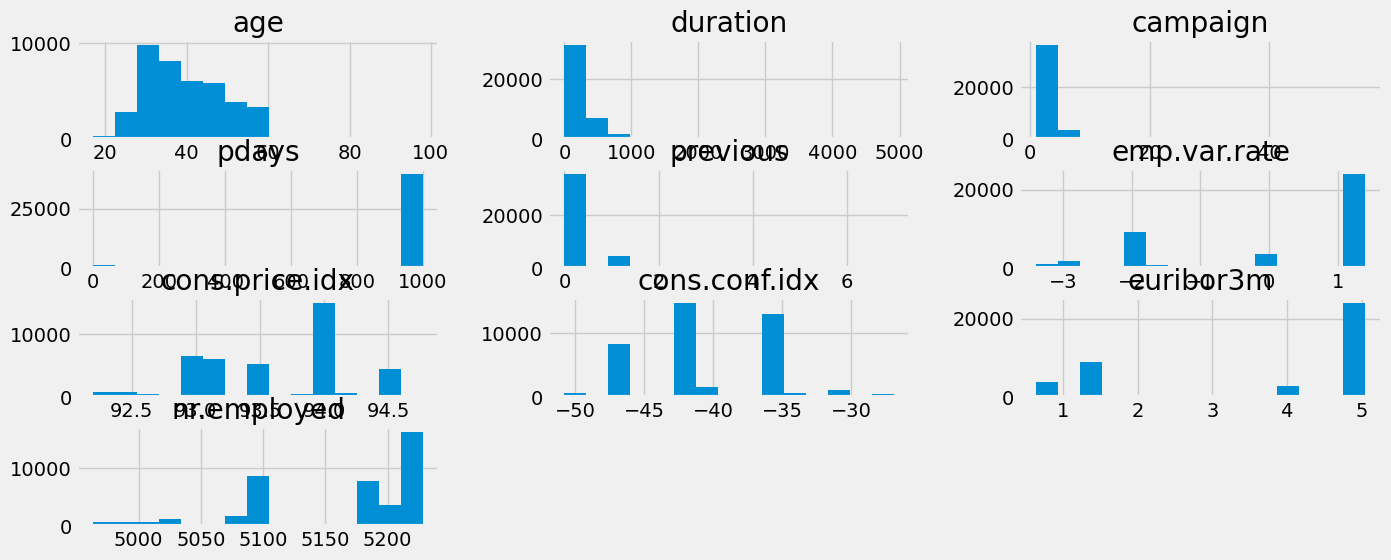

In [14]:
# Visualizing histograms for numerical features
visualizer.plot_histograms(data)

Plots histograms for all numerical features to inspect their distributions.

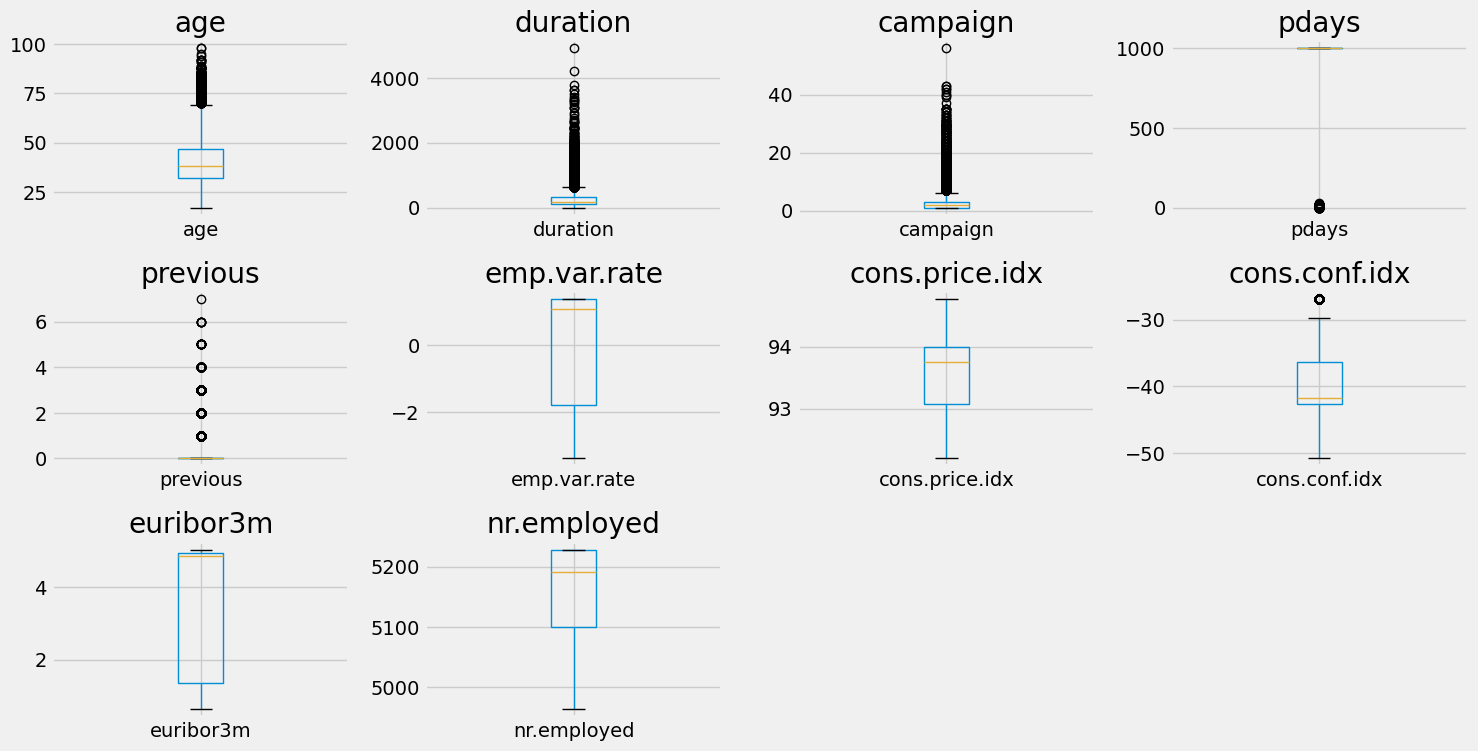

In [15]:
# Visualizing boxplots for numerical features categorized by the target variable
visualizer.plot_boxplots(data)

Creates boxplots for numerical features segmented by the target variable to identify outliers and distribution differences.


--- Crosstab of job by Target 'y' ---
y                no   yes
job                      
admin.         9070  1352
blue-collar    8616   638
entrepreneur   1332   124
housemaid       954   106
management     2596   328
retired        1286   434
self-employed  1272   149
services       3646   323
student         600   275
technician     6013   730
unemployed      870   144
unknown         293    37


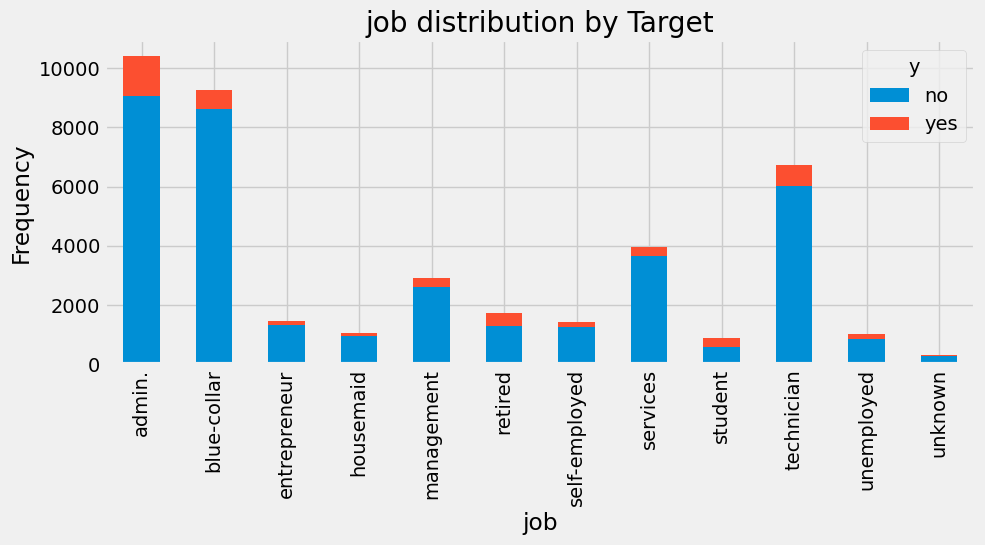


--- Crosstab of marital by Target 'y' ---
y            no   yes
marital              
divorced   4136   476
married   22396  2532
single     9948  1620
unknown      68    12


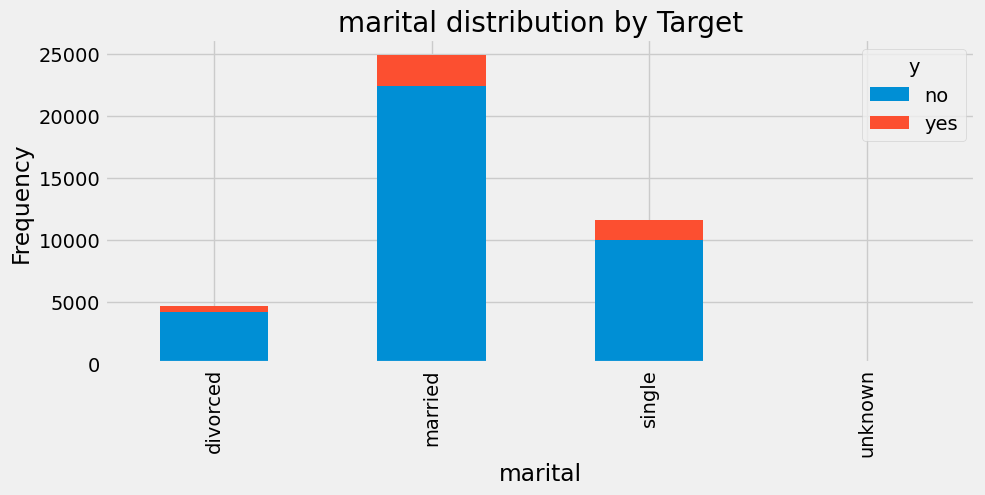


--- Crosstab of education by Target 'y' ---
y                       no   yes
education                       
basic.4y              3748   428
basic.6y              2104   188
basic.9y              5572   473
high.school           8484  1031
illiterate              14     4
professional.course   4648   595
university.degree    10498  1670
unknown               1480   251


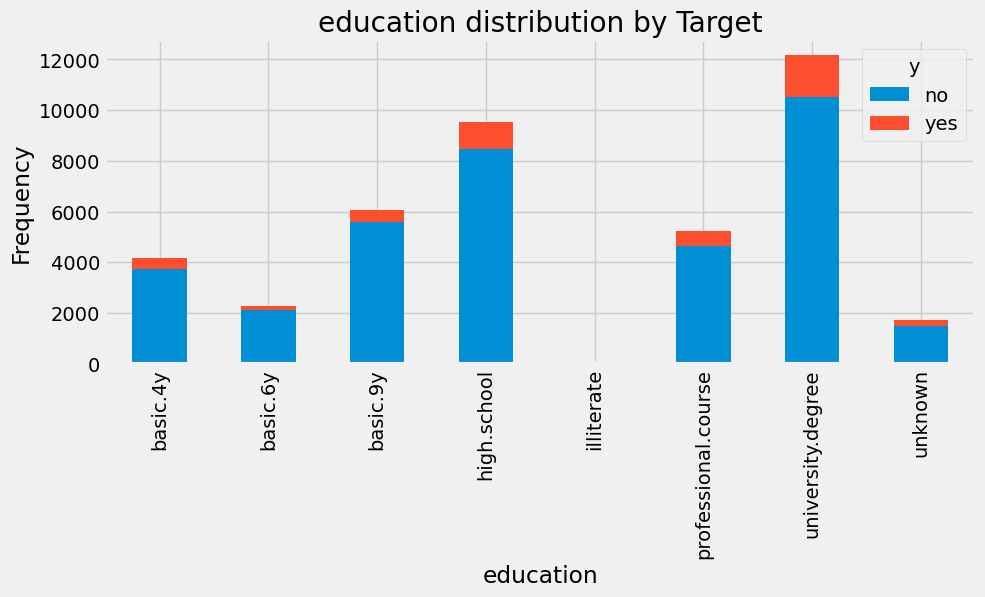


--- Crosstab of default by Target 'y' ---
y           no   yes
default             
no       28391  4197
unknown   8154   443
yes          3     0


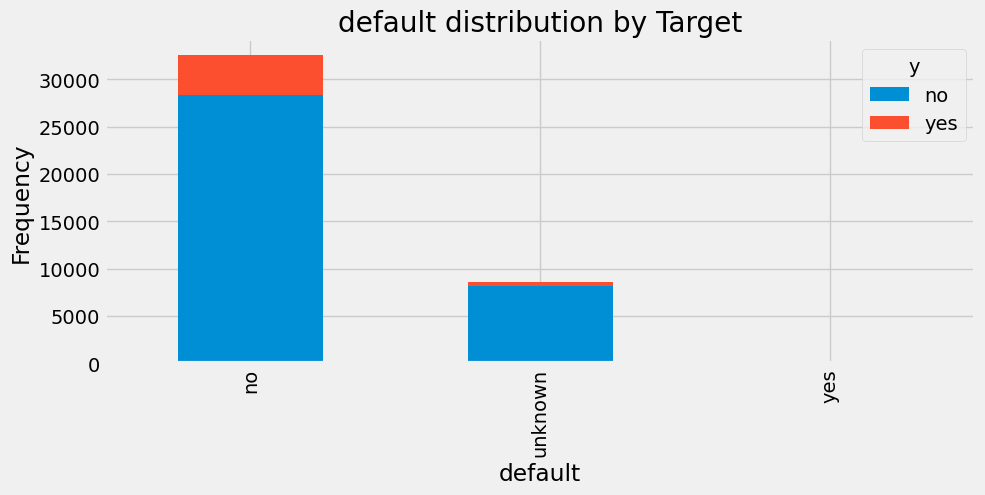


--- Crosstab of housing by Target 'y' ---
y           no   yes
housing             
no       16596  2026
unknown    883   107
yes      19069  2507


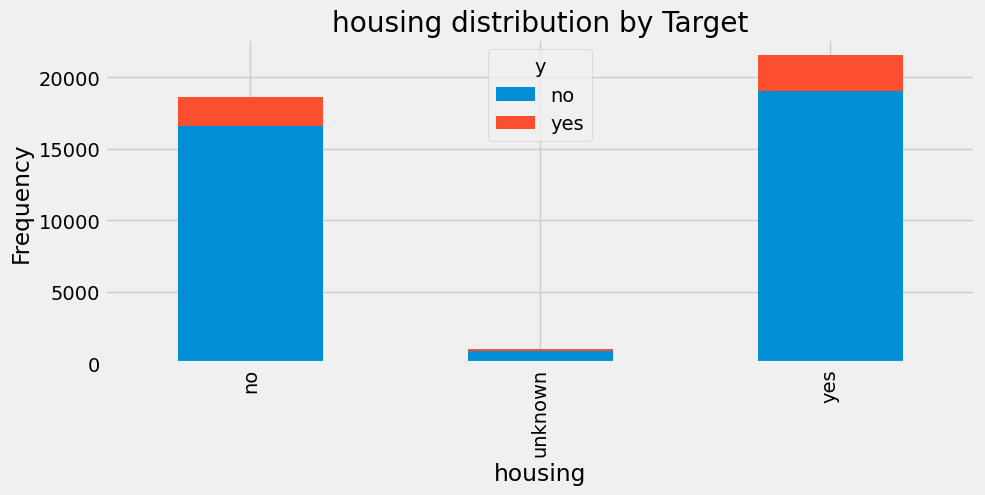


--- Crosstab of loan by Target 'y' ---
y           no   yes
loan                
no       30100  3850
unknown    883   107
yes       5565   683


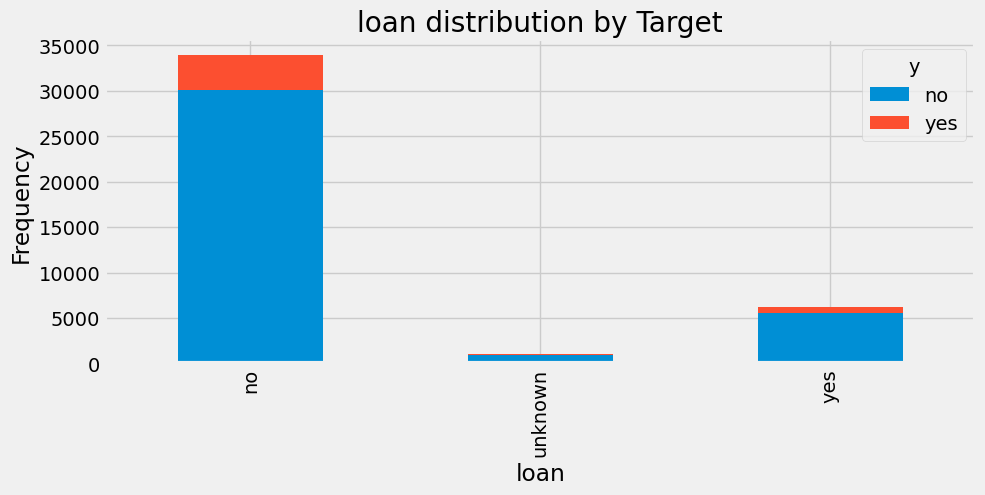


--- Crosstab of contact by Target 'y' ---
y             no   yes
contact               
cellular   22291  3853
telephone  14257   787


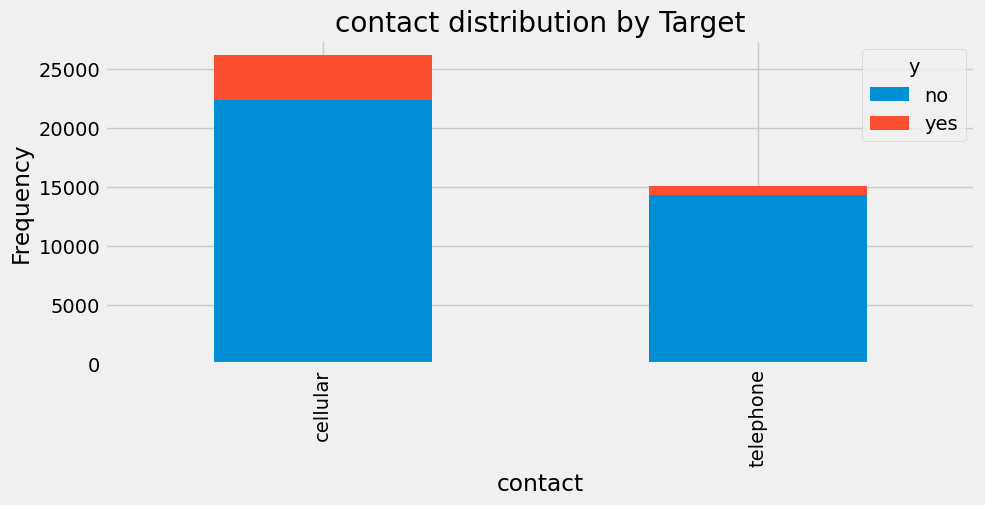


--- Crosstab of month by Target 'y' ---
y         no  yes
month            
apr     2093  539
aug     5523  655
dec       93   89
jul     6525  649
jun     4759  559
mar      270  276
may    12883  886
nov     3685  416
oct      403  315
sep      314  256


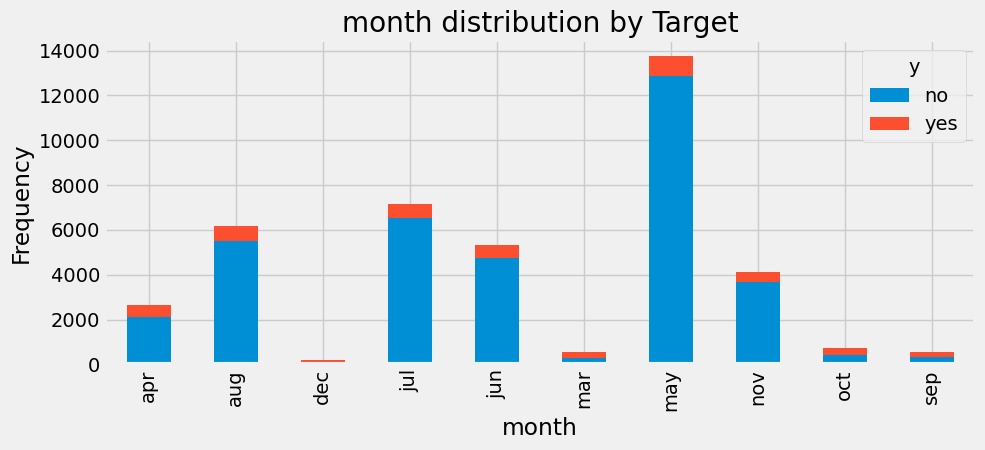


--- Crosstab of day_of_week by Target 'y' ---
y              no   yes
day_of_week            
fri          6981   846
mon          7667   847
thu          7578  1045
tue          7137   953
wed          7185   949


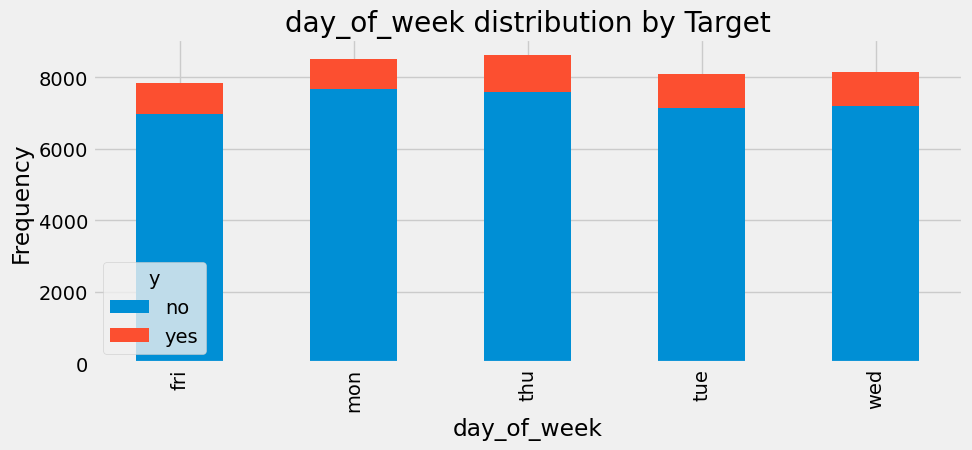


--- Crosstab of poutcome by Target 'y' ---
y               no   yes
poutcome                
failure       3647   605
nonexistent  32422  3141
success        479   894


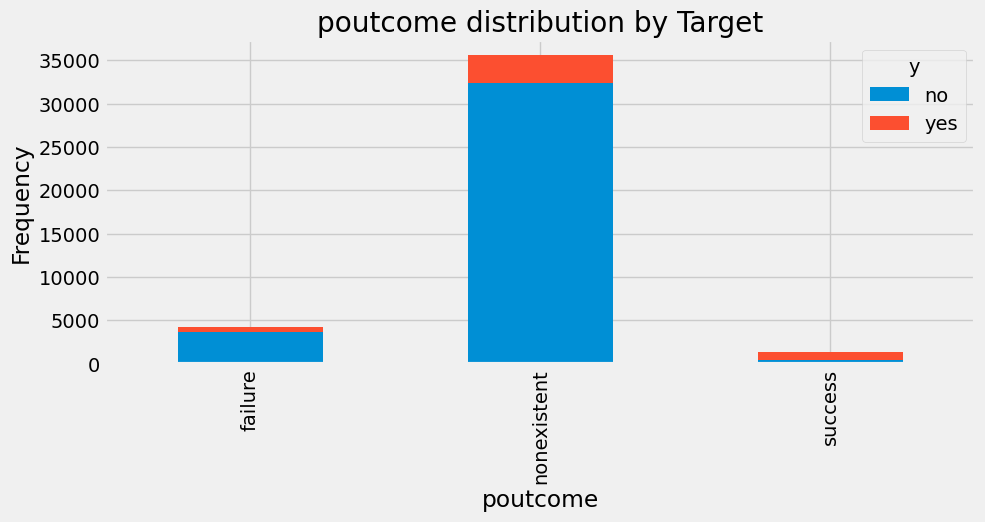

In [16]:
# Visualizing distributions for categorical features
visualizer.plot_categorical_distributions(data)

Plots the distribution of categorical variables to assess frequency and impact on the target.

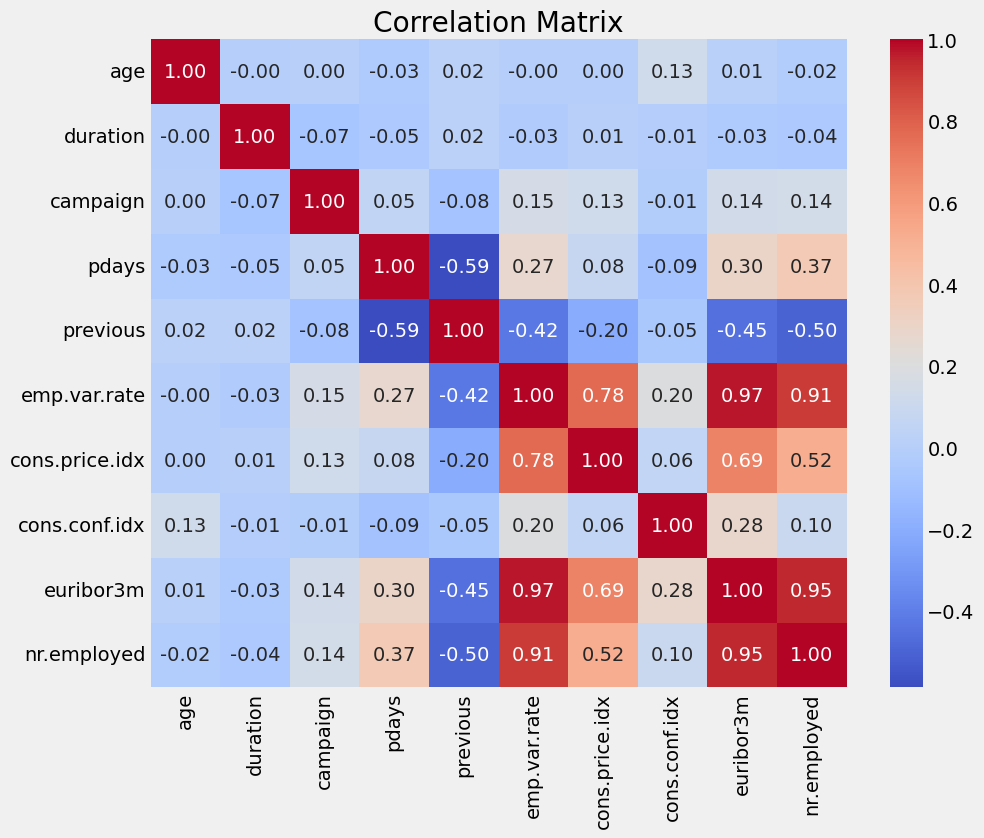

In [17]:
# Visualizing the correlation matrix
visualizer.plot_correlation_matrix(data)

Displays a correlation matrix for features to identify potential multicollinearity and relationships important for prediction.

## Feature Selection Results
This cell outputs the selected features after applying univariate selection, model-based selection, and chi-squared tests. This list includes both numerical and categorical variables deemed most predictive of the outcome based on our feature selection methods.

In [18]:
# Get selected features
print(f"Selected Features:\n{forecast.get_selected_features()}")

Selected Features:
['age', 'duration', 'campaign', 'pdays', 'previous', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed', 'job', 'marital', 'education', 'default', 'contact', 'month', 'day_of_week', 'poutcome']


The selected features for modeling, as determined by univariate selection, model-based selection, and chi-squared tests, include demographic factors (`age`), economic indicators (`emp.var.rate`, `cons.price.idx`, `cons.conf.idx`, `euribor3m`, `nr.employed`), and several others related to the bank's contact strategy (`contact`, `month`, `day_of_week`, `poutcome`). This diverse set of features, encompassing both continuous and categorical variables, reflects the complexity of factors influencing a client's decision to subscribe to a term deposit. The inclusion of job types, marital status, and education highlights the role of socio-economic factors, whereas contact and previous campaign outcomes underscore the importance of engagement strategies.


## Model Retrieval
Retrieves the trained Random Forest model pipeline from our forecast instance. This model is then used to extract feature importances and other model-specific information. Here, we also ensure the features are appropriately indexed for further analysis.


In [19]:
# Get a specific model, e.g., Random Forest
trained_pipeline = forecast.get_model('Random Forest')
# trained_pipeline = model_name.named_steps['classifier']
# trained_pipeline = forecast.models[model_name].named_steps['classifier']
classifier = trained_pipeline.named_steps['classifier']
feature_names = forecast.X_train

## Feature Importance
This cell computes and prints the feature importances derived from the Random Forest model. The importances help in understanding which features are most influential in predicting whether a client will subscribe to a term deposit, aiding in the interpretability of our model.


In [20]:
# Get and plot feature importance
feature_importance = forecast.get_feature_importance(trained_pipeline, feature_names)
print(f"Feature Importance:\n{feature_importance}")

Feature Importance:
                                    importance
num__duration                         0.336258
num__euribor3m                        0.091669
num__nr.employed                      0.079629
num__campaign                         0.043213
num__age                              0.038971
num__cons.conf.idx                    0.028919
num__cons.price.idx                   0.026001
cat__poutcome_success                 0.017526
cat__contact_telephone                0.017226
num__pdays                            0.017197
cat__contact_cellular                 0.016420
cat__default_unknown                  0.015310
cat__education_university.degree      0.013058
cat__day_of_week_mon                  0.012851
cat__default_no                       0.012536
cat__day_of_week_fri                  0.012408
cat__day_of_week_wed                  0.012148
cat__day_of_week_tue                  0.012011
cat__day_of_week_thu                  0.011935
cat__job_admin.                       0.

The Random Forest model's feature importance reveals significant predictors for term deposit subscriptions. `duration` of the last contact has the highest importance (approximately 33.6%), indicating that longer calls might correlate with higher subscription rates. Economic indicators such as `euribor3m` and `nr.employed` also show substantial influence, reflecting the broader economic context's impact on clients' financial decisions. Campaign-related features like `campaign`, `pdays`, and categorical variables like `poutcome_success` and `contact` type also play notable roles. This detailed feature importance helps target specific areas for improving marketing strategies, such as optimizing contact duration and timing.


## Feature Importance Visualization
Visualizes the feature importances obtained from the Random Forest model. This visualization aids in quickly identifying the most significant predictors and understanding their relative importance in the model.


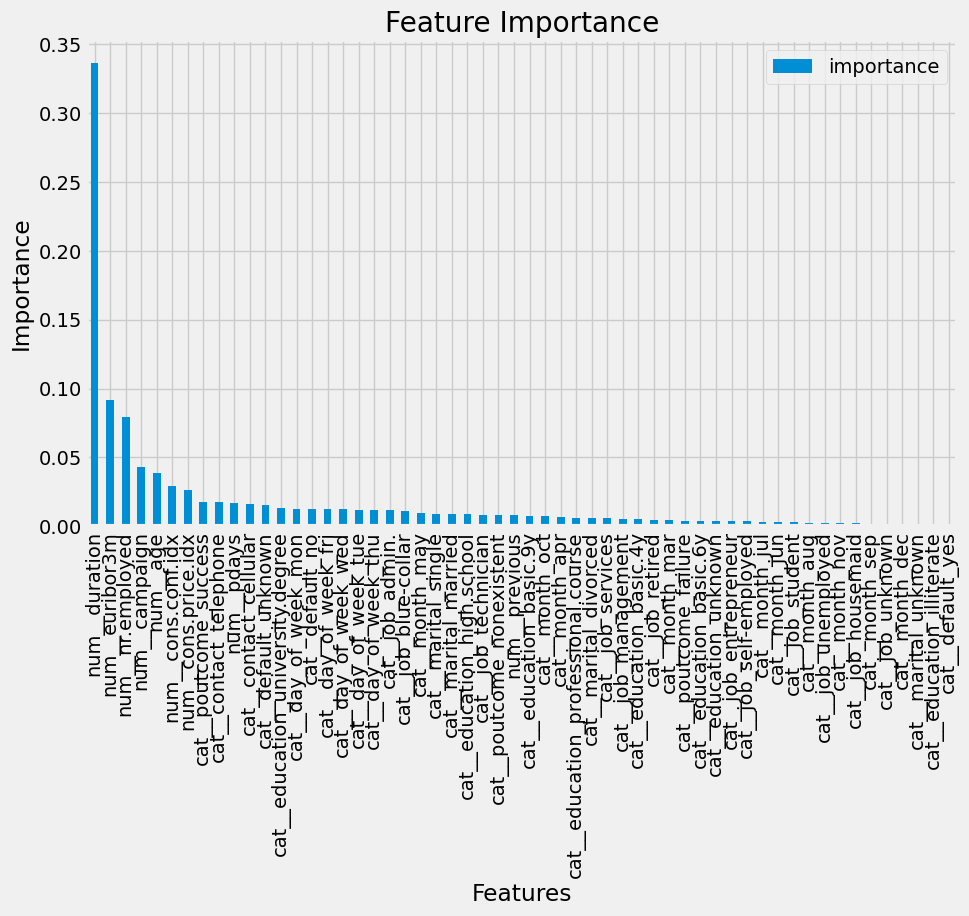

In [21]:
visualizer.plot_feature_importance(feature_importance)

## Model Performance Summary
Displays a summary of the model results, including accuracy, precision, recall, F1 score, and ROC AUC for both the training and testing sets. This comprehensive performance metric review helps in assessing each model's efficacy and selecting the best performer for deployment.


In [22]:
print(f"Model Results:\n{forecast.get_model_results()}")

Model Results:
                 Model  Train Accuracy  Test Accuracy  Train Precision  \
0  Logistic Regression        0.860789       0.867565         0.440517   
1        Random Forest        0.999970       0.915756         0.999731   
2                  SVM        0.848012       0.852027         0.418919   

   Test Precision  Train Recall  Test Recall  Train F1   Test F1  Test ROC AUC  
0        0.455874      0.872845     0.907328  0.585525  0.606847      0.942434  
1        0.622642      1.000000     0.640086  0.999865  0.631243      0.946535  
2        0.427504      0.901940     0.924569  0.572112  0.584668      0.941707  


This cell presents a summary of the model performance metrics. The Random Forest model exhibits the highest Test ROC AUC (0.946535), suggesting superior ability to discriminate between subscribers and non-subscribers compared to Logistic Regression and SVM. Despite its high training metrics, indicating possible overfitting (Train Accuracy near 100%, Train Precision near 100%), it maintains robust test performance, especially in precision and recall. Logistic Regression and SVM show more balanced performance between training and testing but with lower precision and recall on the test set. The results underscore Random Forest's effectiveness for this prediction task, but also highlight the need for careful tuning to balance the model's generalization capabilities.


## ROC Curve Plotting
Plots the ROC curves for the evaluated models, providing a graphical representation of their performance across different classification thresholds. This visualization is crucial for understanding model performance in terms of the trade-off between sensitivity and specificity.


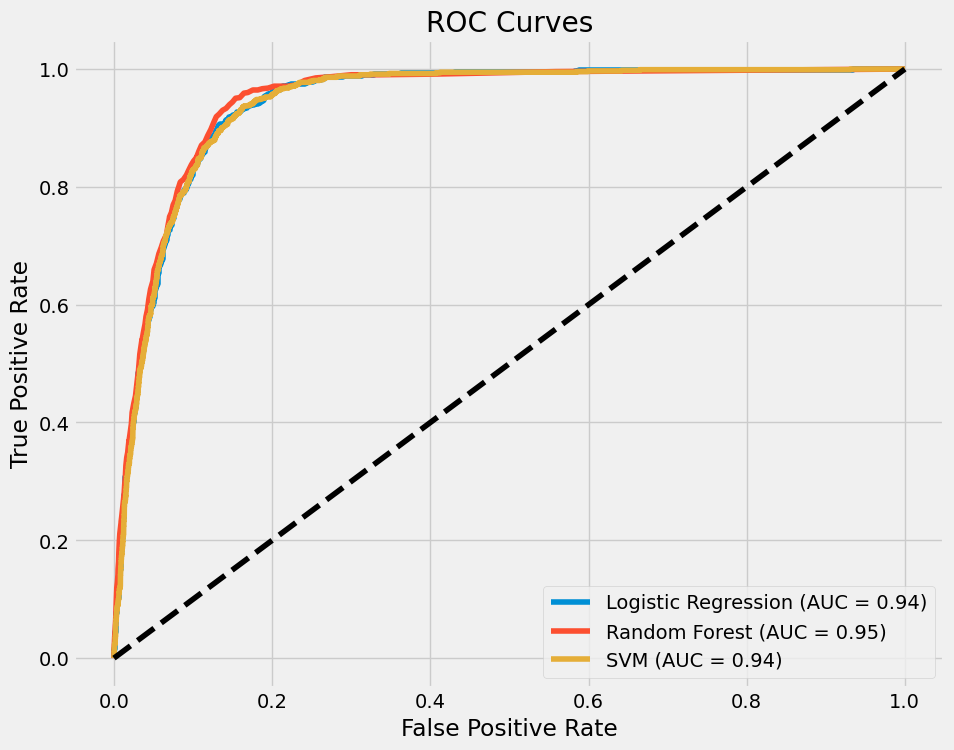

In [23]:
visualizer.plot_roc_curves(roc_data)

# Conclusion

The `TermDepositMLForecast` project successfully applied three machine learning models—Logistic Regression, Random Forest, and SVM—to predict whether clients will subscribe to a term deposit. Our analysis revealed that the Random Forest model provided the best performance in terms of accuracy and ROC AUC, indicating its superior capability in handling the complexity of the dataset.

Key findings from our feature importance analysis highlighted that the duration of the last contact, several economic indicators, and the outcome of previous campaigns were critical in influencing clients' decisions. These insights suggest that enhancing client interaction quality and timing could significantly impact subscription rates.

However, the variance in performance metrics, particularly the difference in training and testing accuracy for the Random Forest model, suggests a potential overfitting issue that needs addressing in future model tuning efforts.
